In [54]:
!pip install statsmodels


In [55]:
!pip install statsmodels seaborn scikit-learn

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder



In [57]:
file_path = r'C:\Users\wasee\OneDrive\Desktop\city_day.csv'  
air_quality_data = pd.read_csv(file_path)

In [58]:
print("First few rows of the dataset:")
print(air_quality_data.head())

First few rows of the dataset:
        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  


In [59]:
print("\nColumn names in the dataset:")
print(air_quality_data.columns)


Column names in the dataset:
Index(['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


In [60]:
print("\nSummary statistics of the dataset:")
print(air_quality_data.describe(include='all'))




Summary statistics of the dataset:
             City        Date         PM2.5          PM10            NO  \
count       29531       29531  24933.000000  18391.000000  25949.000000   
unique         26        2009           NaN           NaN           NaN   
top     Ahmedabad  2020-07-01           NaN           NaN           NaN   
freq         2009          26           NaN           NaN           NaN   
mean          NaN         NaN     67.450578    118.127103     17.574730   
std           NaN         NaN     64.661449     90.605110     22.785846   
min           NaN         NaN      0.040000      0.010000      0.020000   
25%           NaN         NaN     28.820000     56.255000      5.630000   
50%           NaN         NaN     48.570000     95.680000      9.890000   
75%           NaN         NaN     80.590000    149.745000     19.950000   
max           NaN         NaN    949.990000   1000.000000    390.680000   

                 NO2           NOx           NH3            CO 

In [61]:
print("\nMissing values in the dataset:")
print(air_quality_data.isnull().sum())


Missing values in the dataset:
City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64


In [62]:
numeric_columns = air_quality_data.select_dtypes(include=['number']).columns
air_quality_data_cleaned = air_quality_data.copy()
air_quality_data_cleaned[numeric_columns] = air_quality_data_cleaned[numeric_columns].fillna(air_quality_data_cleaned[numeric_columns].median())

In [63]:
categorical_columns = air_quality_data_cleaned.select_dtypes(include=['object']).columns
for column in categorical_columns:
    air_quality_data_cleaned[column].fillna(air_quality_data_cleaned[column].mode()[0], inplace=True)

C:\Users\wasee\AppData\Local\Temp\ipykernel_3876\3283525474.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  air_quality_data_cleaned[column].fillna(air_quality_data_cleaned[column].mode()[0], inplace=True)


In [64]:
air_quality_data_cleaned = air_quality_data_cleaned.drop_duplicates()


In [65]:
air_quality_data_cleaned['PM2.5_MA_7'] = air_quality_data_cleaned['PM2.5'].rolling(window=7).mean().fillna(method='bfill')


C:\Users\wasee\AppData\Local\Temp\ipykernel_3876\4246372739.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  air_quality_data_cleaned['PM2.5_MA_7'] = air_quality_data_cleaned['PM2.5'].rolling(window=7).mean().fillna(method='bfill')


In [66]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = pd.DataFrame(encoder.fit_transform(air_quality_data_cleaned[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))


In [67]:
air_quality_data_cleaned = air_quality_data_cleaned.drop(columns=categorical_columns).reset_index(drop=True)
air_quality_data_cleaned = pd.concat([air_quality_data_cleaned, encoded_features], axis=1)


In [68]:
features_to_scale = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO', 'PM2.5_MA_7']
scaler = StandardScaler()
air_quality_data_cleaned[features_to_scale] = scaler.fit_transform(air_quality_data_cleaned[features_to_scale])

print("First few rows after preprocessing:")
print(air_quality_data_cleaned.head())

First few rows after preprocessing:
     PM2.5      PM10     NO       NO2    NOx    NH3        CO       SO2  \
0 -0.26654 -0.193291   0.92 -0.412430  17.15  15.85 -0.183488  0.812044   
1 -0.26654 -0.193291   0.97 -0.522191  16.46  15.85 -0.176052  0.630337   
2 -0.26654 -0.193291  17.40 -0.365576  29.70  15.85  2.267235  0.896135   
3 -0.26654 -0.193291   1.70 -0.401151  17.97  15.85 -0.067495  0.279859   
4 -0.26654 -0.193291  22.10 -0.273602  37.76  15.85  2.966167  1.499475   

         O3  Benzene  ...  Date_2020-06-27  Date_2020-06-28  Date_2020-06-29  \
0  4.918625     0.00  ...              0.0              0.0              0.0   
1  0.003261     3.68  ...              0.0              0.0              0.0   
2 -0.163059     6.80  ...              0.0              0.0              0.0   
3  0.103251     4.43  ...              0.0              0.0              0.0   
4  0.263137     7.01  ...              0.0              0.0              0.0   

   Date_2020-06-30  Date_2020-07

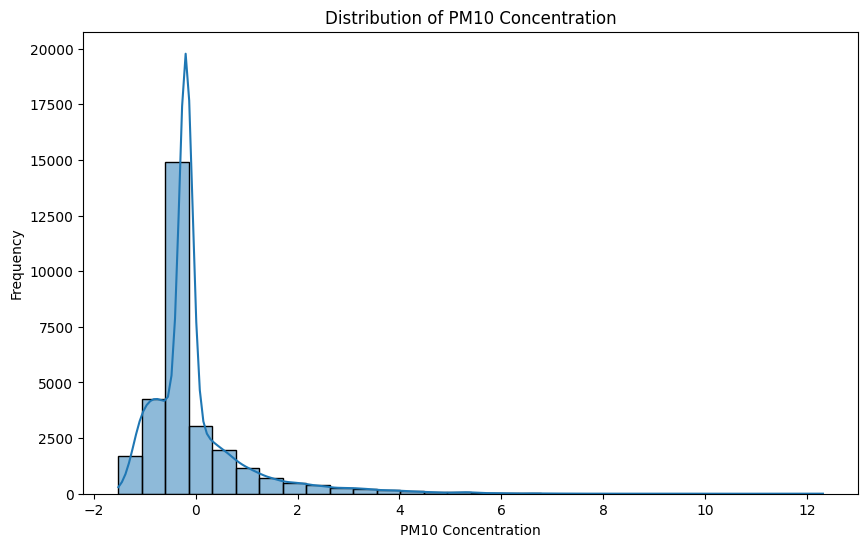

In [69]:
plt.figure(figsize=(10, 6))
sns.histplot(air_quality_data_cleaned['PM10'], kde=True, bins=30)
plt.title('Distribution of PM10 Concentration')
plt.xlabel('PM10 Concentration')
plt.ylabel('Frequency')
plt.show()

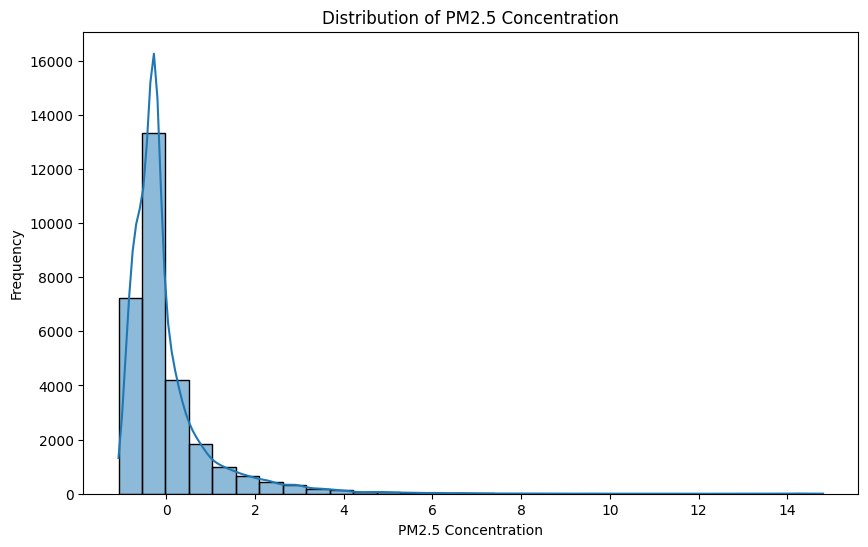

In [70]:
plt.figure(figsize=(10, 6))
sns.histplot(air_quality_data_cleaned['PM2.5'], kde=True, bins=30)
plt.title('Distribution of PM2.5 Concentration')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Frequency')
plt.show()

In [71]:
if 'Date' in air_quality_data.columns:
    air_quality_data['Date'] = pd.to_datetime(air_quality_data['Date'])
    air_quality_data.set_index('Date', inplace=True)
else:
    print("Error: 'Date' column not found in the dataset. Please check the column names.")
if 'PM2.5' in air_quality_data.columns:
    air_quality_data['PM2.5'].interpolate(method='linear', inplace=True)
    air_quality_data['PM2.5'].fillna(method='bfill', inplace=True)  
else:
    print("Error: 'PM2.5' column not found in the dataset.")

print("\nMissing values in 'PM2.5' after interpolation and backfill:")
print(air_quality_data['PM2.5'].isnull().sum())




Missing values in 'PM2.5' after interpolation and backfill:
0


C:\Users\wasee\AppData\Local\Temp\ipykernel_3876\2341169309.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  air_quality_data['PM2.5'].interpolate(method='linear', inplace=True)
C:\Users\wasee\AppData\Local\Temp\ipykernel_3876\2341169309.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

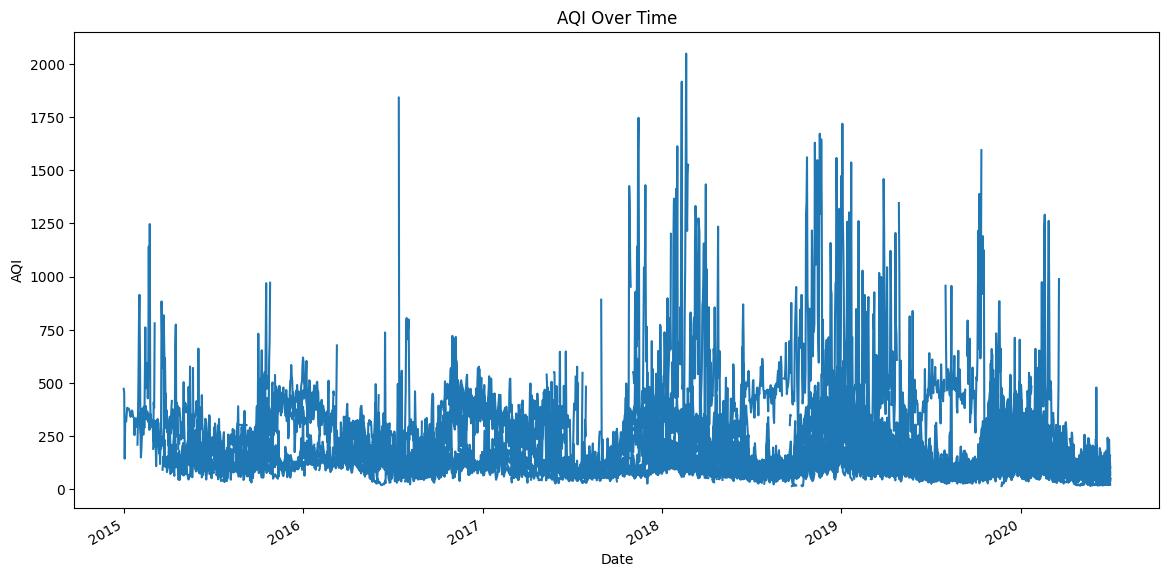

In [72]:
if 'AQI' in air_quality_data.columns:
    plt.figure(figsize=(14, 7))
    air_quality_data['AQI'].plot()
    plt.title('AQI Over Time')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.show()
else:
    print("Error: 'AQI' column not found in the dataset.")

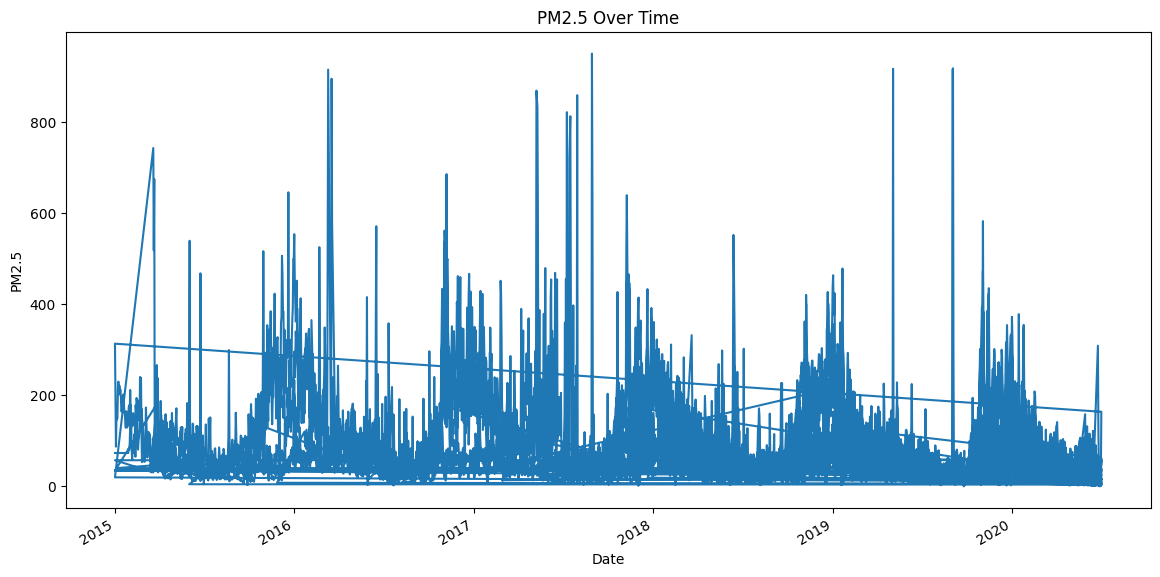

In [73]:
if 'PM2.5' in air_quality_data.columns:
    plt.figure(figsize=(14, 7))
    air_quality_data['PM2.5'].plot()
    plt.title('PM2.5 Over Time')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.show()
else:
    print("Error: 'PM2.5' column not found in the dataset.")

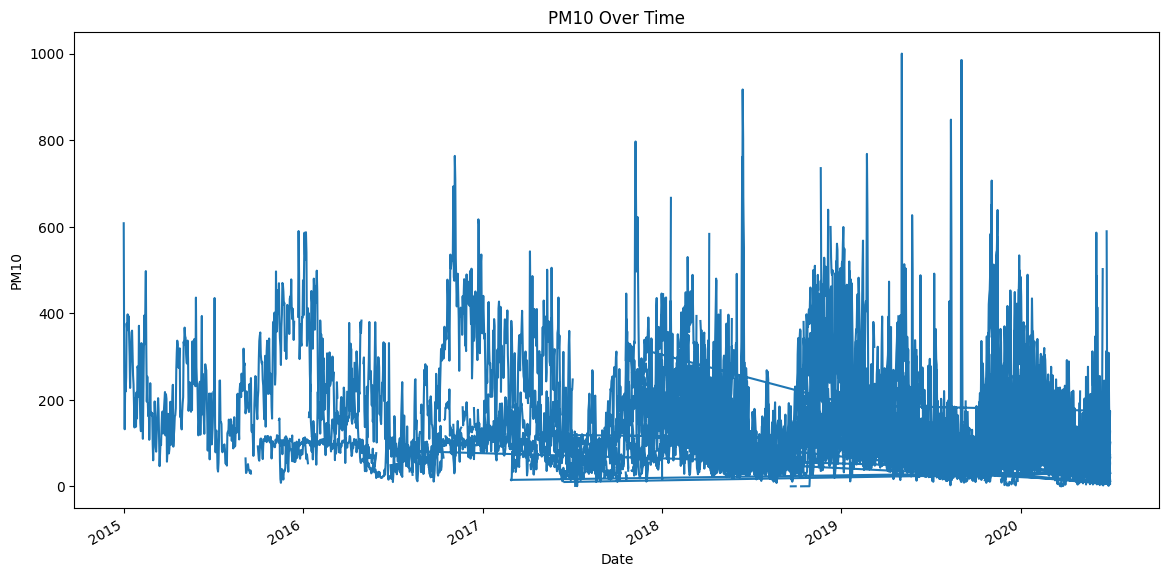

In [74]:
if 'PM10' in air_quality_data.columns:
    plt.figure(figsize=(14, 7))
    air_quality_data['PM10'].plot()
    plt.title('PM10 Over Time')
    plt.xlabel('Date')
    plt.ylabel('PM10')
    plt.show()
else:
    print("Error: 'PM10' column not found in the dataset.")


In [75]:
print("Length of the dataset:", len(air_quality_data))

Length of the dataset: 29531


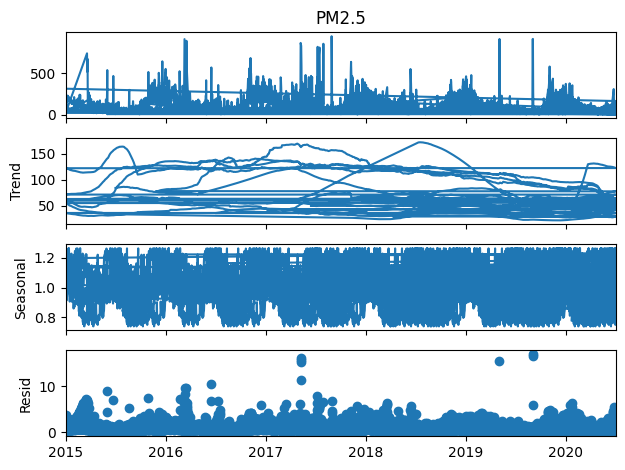

In [76]:
if len(air_quality_data) >= 365 and 'PM2.5' in air_quality_data.columns:
    result = seasonal_decompose(air_quality_data['PM2.5'], model='multiplicative', period=365)
    result.plot()
    plt.show()
else:
    print("Dataset is not long enough for seasonal decomposition with a period of 365 or 'PM2.5' column not found.")


In [77]:
air_quality_data = air_quality_data.dropna(axis=1, how='all')  
air_quality_data = air_quality_data.dropna(axis=0) 

In [78]:
print(air_quality_data.dtypes)

City           object
PM2.5         float64
PM10          float64
NO            float64
NO2           float64
NOx           float64
NH3           float64
CO            float64
SO2           float64
O3            float64
Benzene       float64
Toluene       float64
Xylene        float64
AQI           float64
AQI_Bucket     object
dtype: object


In [79]:
categorical_columns = air_quality_data.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_columns}")


Categorical columns: ['City', 'AQI_Bucket']


In [80]:
label_encoder = LabelEncoder()
for col in categorical_columns:
    air_quality_data[col] = label_encoder.fit_transform(air_quality_data[col])

In [81]:
target_column = 'PM2.5'  
X = air_quality_data.drop(target_column, axis=1)
y = air_quality_data[target_column]


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [83]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=10, random_state=42), 
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

In [84]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse}, R^2: {r2}")

Linear Regression - MSE: 356.5693318911313, R^2: 0.8863519919274997
Decision Tree - MSE: 355.61641315573826, R^2: 0.886655712148075
Random Forest - MSE: 194.1113765514157, R^2: 0.9381316077513504
Gradient Boosting - MSE: 161.48106024087394, R^2: 0.9485317462932734


In [85]:
best_model = RandomForestRegressor(n_estimators=50, random_state=42) 
best_model_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print(f"Best Model (Random Forest) Cross-Validation R^2 scores: {best_model_scores}")
print(f"Best Model (Random Forest) Cross-Validation R^2 mean score: {best_model_scores.mean()}")

Best Model (Random Forest) Cross-Validation R^2 scores: [0.86436067 0.83772407 0.85132177 0.91420527 0.73379824]
Best Model (Random Forest) Cross-Validation R^2 mean score: 0.8402820050847767


In [86]:
best_model.fit(X, y)

RandomForestRegressor(n_estimators=50, random_state=42)

In [87]:
if isinstance(best_model, RandomForestRegressor) or isinstance(best_model, GradientBoostingRegressor):
    feature_importances = best_model.feature_importances_
    feature_names = X.columns


    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

In [91]:
 feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
   

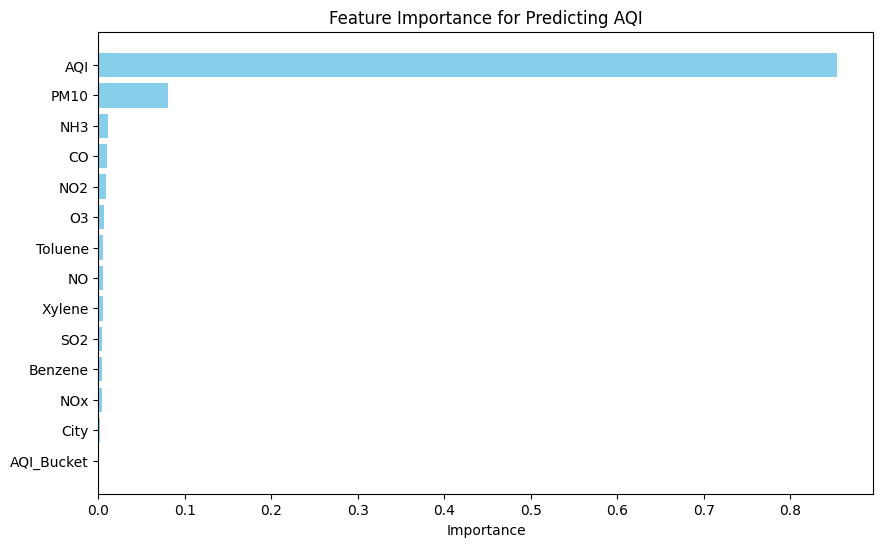

In [96]:

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for Predicting AQI')
plt.gca().invert_yaxis()  
plt.show()
